In [99]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [112]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def show_uprights(uprights, max_cols=4, title="Upright pieces"):
    """
    Show all upright piece images in a grid with indices.

    Parameters
    ----------
    uprights : list of np.ndarray
        List of piece images in BGR (from OpenCV).
    max_cols : int
        Maximum number of columns in the display grid.
    title : str
        Suptitle for the whole figure.
    """
    N = len(uprights)
    if N == 0:
        print("No pieces to display.")
        return
    
    cols = min(max_cols, N)
    rows = int(np.ceil(N / cols))

    plt.figure(figsize=(3*cols, 3*rows))
    for idx, piece in enumerate(uprights):
        plt.subplot(rows, cols, idx + 1)
        # uprights are BGR from OpenCV → convert to RGB for matplotlib
        rgb = cv2.cvtColor(piece, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb)
        plt.axis("off")
        plt.title(str(idx), fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [113]:
import os, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

# ============================================================
#  Basic helpers
# ============================================================

# side indices: 0=top, 1=right, 2=bottom, 3=left
OPP = {0: 2, 1: 3, 2: 0, 3: 1}

def rot90n(img, n):
    n %= 4
    if n == 0: return img
    if n == 1: return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    if n == 2: return cv2.rotate(img, cv2.ROTATE_180)
    return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

# ---------- RGB (.rgb) reader with auto layout detection ----------

def read_rgb_raw_auto(path):
    size   = os.path.getsize(path)
    pixels = size // 3
    side   = int(round(pixels ** 0.5))

    with open(path, "rb") as f:
        raw = np.frombuffer(f.read(), dtype=np.uint8)

    # candidate 1: interleaved H×W×3
    inter = raw.reshape((side, side, 3))
    inter_bgr = cv2.cvtColor(inter, cv2.COLOR_RGB2BGR)

    # candidate 2: planar 3×H×W
    planar = raw.reshape((3, side, side)).transpose(1, 2, 0)
    planar_bgr = cv2.cvtColor(planar, cv2.COLOR_RGB2BGR)

    def colorfulness(bgr):
        b, g, r = cv2.split(bgr.astype(np.float32))
        return float(np.mean(np.std(np.stack([b, g, r], axis=-1), axis=-1)))

    return planar_bgr if colorfulness(planar_bgr) > colorfulness(inter_bgr) else inter_bgr

def read_image_auto(path):
    ext = os.path.splitext(path.lower())[1]
    if ext == ".rgb":
        return read_rgb_raw_auto(path)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return img

# ============================================================
#  Segmentation
# ============================================================

def segment_pieces(bgr, thresh=None, min_area=300):
    """
    Segment rectangular pieces against dark background.

    If thresh is None, choose it adaptively from darkest 5% of pixels.
    """
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    if thresh is None:
        flat = gray.reshape(-1)
        p5   = np.percentile(flat, 5)
        thr  = p5 + 3
        thr  = max(1, min(50, thr))
    else:
        thr = thresh

    mask = (gray > thr).astype(np.uint8)

    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)

    pieces = []
    for i in range(1, num):
        x, y, w, h, area = stats[i]
        if area < min_area:
            continue
        crop  = bgr[y:y+h, x:x+w]
        cmask = (labels[y:y+h, x:x+w] == i).astype(np.uint8)
        pieces.append({"crop": crop, "mask": cmask})
    return pieces

# ============================================================
#  Deskew for a single piece
# ============================================================

def tight_crop_by_mask(crop, mask):
    ys, xs = np.where(mask > 0)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1
    return crop[y0:y1, x0:x1], mask[y0:y1, x0:x1]

def deskew_piece_masked(piece, do_deskew=False):
    """
    piece: {"crop": bgr, "mask": uint8}

    If do_deskew=False (translate case):
        - just tight-crop to the mask (no rotation).

    If do_deskew=True (rotate case):
        - estimate minAreaRect on the mask pixels,
        - rotate crop+mask by the rectangle angle (OpenCV convention),
        - tight-crop again to the new mask.
    """
    crop = piece["crop"]
    mask = piece["mask"]

    # initial tight crop so we don't carry big borders
    crop, mask = tight_crop_by_mask(crop, mask)

    if not do_deskew:
        return crop, mask

    ys, xs = np.where(mask > 0)
    pts = np.vstack([xs, ys]).T.astype(np.float32)

    rect  = cv2.minAreaRect(pts)    # (center, (w,h), angle)
    angle = rect[2]                 # OpenCV: angle in [-90,0)

    # bring angle into [-45, 45] to remove just the tilt
    if angle < -45.0:
        angle = 90.0 + angle

    h, w = crop.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    rot  = cv2.warpAffine(crop, M, (w, h),
                          flags=cv2.INTER_LINEAR,
                          borderValue=(0,0,0))
    rmask = cv2.warpAffine(mask, M, (w, h),
                           flags=cv2.INTER_NEAREST,
                           borderValue=0)

    rot, rmask = tight_crop_by_mask(rot, rmask)
    return rot, rmask

# ============================================================
#  Edge signatures (mask-aware)
# ============================================================

def edge_signature_masked(bgr, mask, side, strip=3, N=128):
    """
    Build a 1D color+gradient signature along a side, using only mask==1 pixels
    to avoid aliasing/background.
    side: 0=top,1=right,2=bottom,3=left
    """
    h, w, _ = bgr.shape
    strip2 = min(strip*2, h if side in (0,2) else w)

    line_cols = []

    if side == 0:       # top
        for x in range(w):
            band_m = mask[0:strip2, x]
            band_c = bgr[0:strip2, x]
            pix = band_c[band_m.astype(bool)] if np.any(band_m) else band_c.reshape(-1,3)
            line_cols.append(pix.mean(axis=0))
    elif side == 2:     # bottom
        for x in range(w):
            band_m = mask[h-strip2:h, x]
            band_c = bgr[h-strip2:h, x]
            pix = band_c[band_m.astype(bool)] if np.any(band_m) else band_c.reshape(-1,3)
            line_cols.append(pix.mean(axis=0))
    elif side == 1:     # right
        for y in range(h):
            band_m = mask[y, w-strip2:w]
            band_c = bgr[y, w-strip2:w]
            pix = band_c[band_m.astype(bool)] if np.any(band_m) else band_c.reshape(-1,3)
            line_cols.append(pix.mean(axis=0))
    else:               # left
        for y in range(h):
            band_m = mask[y, 0:strip2]
            band_c = bgr[y, 0:strip2]
            pix = band_c[band_m.astype(bool)] if np.any(band_m) else band_c.reshape(-1,3)
            line_cols.append(pix.mean(axis=0))

    line = np.asarray(line_cols, dtype=np.uint8)   # (L,3)

    lab = cv2.cvtColor(line.reshape(-1,1,3), cv2.COLOR_BGR2LAB)\
             .reshape(-1,3).astype(np.float32)

    src = np.linspace(0, len(lab)-1, len(lab), dtype=np.float32)
    dst = np.linspace(0, len(lab)-1, N,          dtype=np.float32)
    res = np.vstack([np.interp(dst, src, lab[:,c]) for c in range(3)]).T  # (N,3)

    grad = np.gradient(res, axis=0)
    sig  = np.hstack([res, grad])   # (N,6)
    return sig

# ============================================================
#  Load puzzle pieces + rotations + signatures (MASK VERSION)
# ============================================================

def load_puzzle_pieces_masked(path, Nsig=128, mode=None):
    """
    mode:
      - "translate": pieces are already axis-aligned rectangles → no deskew.
      - "rotate":    each piece may be tilted → per-piece deskew.

    If mode is None, we infer it from the filename:
      if "rotate" in basename.lower() -> "rotate"
      else -> "translate"
    """
    if mode is None:
        base = os.path.basename(path).lower()
        mode = "rotate" if "rotate" in base else "translate"

    print("Reading input...")
    bgr = read_image_auto(path)

    print("Segmenting pieces...")
    comps = segment_pieces(bgr)
    print(f"Found {len(comps)} pieces.")

    do_deskew = (mode == "rotate")
    if do_deskew:
        print("Deskewing pieces (per-piece minAreaRect)...")
    else:
        print("Translate mode: no deskewing, just tight crop.")

    uprights, masks = [], []
    for p in comps:
        img_u, mask_u = deskew_piece_masked(p, do_deskew=do_deskew)
        uprights.append(img_u)
        masks.append(mask_u)

    print("Building rotations + mask-aware signatures...")
    rotations        = []
    rotations_masks  = []
    sigs             = {}

    for i, (img_u, mask_u) in enumerate(zip(uprights, masks)):
        rots = []
        rmsk = []
        for r in range(4):
            rots.append(rot90n(img_u, r))
            rmsk.append(rot90n(mask_u, r))
        rotations.append(rots)
        rotations_masks.append(rmsk)

        for r in range(4):
            img_r = rots[r]
            msk_r = rmsk[r]
            for s in range(4):
                sigs[(i,r,s)] = edge_signature_masked(img_r, msk_r, s, strip=3, N=Nsig)

    print("Done preprocessing (aliasing-safe).")
    return uprights, masks, rotations, rotations_masks, sigs

# ============================================================
#  Visual helper
# ============================================================

def show_uprights(uprights, max_cols=5, title="Uprights"):
    N = len(uprights)
    cols = min(max_cols, N)
    rows = int(np.ceil(N / cols))
    plt.figure(figsize=(3*cols, 3*rows))
    for i, piece in enumerate(uprights):
        plt.subplot(rows, cols, i+1)
        plt.imshow(cv2.cvtColor(piece, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(str(i), fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# ============================================================
#  Simple neighbor-based solver (your friend’s logic)
# ============================================================

def get_image_bounds(pieces):
    total_width = 0
    total_height = 0
    total_volume = 0
    for p in pieces:
        total_width += p.shape[1]
        total_height += p.shape[0]
        total_volume += p.shape[1]*p.shape[0]
    side_length = math.sqrt(total_volume)
    return round(total_height/side_length), round(total_width/side_length), round(side_length)
    

def solve(pieces: list):
    total_difference = float('inf')
    ordered_pieces = []

    heightp, widthp, side_len = get_image_bounds(pieces)
    print("Estimated grid:", heightp, "x", widthp, "side_len", side_len)
    
    for i in range(len(pieces)):
        print("starting iteration:", i)
        pcopy = pieces.copy()
        currp = pcopy[i]
        pcopy.pop(i)
        pos = [0,0]
        grid = np.full((widthp, heightp), -1)
        temporder = [[currp, pos]]
        direction = "r"
        oppdir = "l"
        pos = [0, 1]
        grid[0][0] = 1
        result = recursive_solver(currp, pcopy, temporder, direction, oppdir, pos, grid)

        if result[0] < total_difference:
            total_difference = result[0]
            ordered_pieces = result[1]

    return ordered_pieces


def recursive_solver(currp, pcopy, temporder, direction, oppdir, pos, grid):

    # base case
    if len(pcopy) <= 1:
        edge = return_edge(currp, direction)
        edge2 = return_edge(pcopy[0], oppdir)
        neworder = temporder + [[pcopy[0], pos]]
        return [get_squared_difference(edge, edge2, oppdir), neworder]

    edge = return_edge(currp, direction)
    matches = find_matching_edge(edge, pcopy, oppdir)

    best_diff = float('inf')
    sol = None
    
    for i in range(min(1, len(pcopy))):
        neworder = temporder + [[matches[i][1], pos]]
        c = pcopy.copy()
        c.pop(matches[i][2])
        g = grid.copy()
        g[pos[0]][pos[1]] = 1
        if direction == 'r' and (pos[1]+1 >= g.shape[1] or g[pos[0]][pos[1]+1] == 1):
            direction = 'b'
            oppdir = 't'
        elif direction == 'b' and (pos[0]+1 >= g.shape[0] or g[pos[0]+1][pos[1]] == 1):
            direction = 'l'
            oppdir = 'r'
        elif direction == 'l' and (pos[1]-1 < 0 or g[pos[0]][pos[1]-1] == 1):
            direction = 't'
            oppdir = 'b'
        elif direction == 't' and g[pos[0]-1][pos[1]] == 1:
            direction = 'r'
            oppdir = 'l'
        pos = update_pos_squares(pos, direction)
        try:
            g[pos[0]][pos[1]] = 1
        except IndexError:
            print("Index error in recursive_solver, pos:", pos)
            print("grid shape:", g.shape)

        solve_res = recursive_solver(matches[i][1], c, neworder, direction, oppdir, pos, g)
        if solve_res[0] < best_diff:
            best_diff = solve_res[0] + matches[i][0]
            sol = solve_res[1]
    
    return [best_diff, sol]

def return_edge(piece, edge):
    if edge == "t":
        return piece[0, :, :]
    elif edge == "b":
        return piece[-1, :, :]
    elif edge == "r":
        return piece[:, -1, :]
    elif edge == "l":
        return piece[:, 0, :]
    return None

def update_pos_squares(pos, direction):
    if direction == "t":
        return [pos[0]-1, pos[1]]
    elif direction == "b":
        return [pos[0]+1, pos[1]]
    elif direction == "r":
        return [pos[0], pos[1]+1]
    elif direction == "l":
        return [pos[0], pos[1]-1]
    return None
    

def find_matching_edge(edge, pieces, direction):

    edge_list = []
    
    for p in range(len(pieces)):
        matching_edge = return_edge(pieces[p], direction)
        diff = get_squared_difference(edge, matching_edge, direction)
        edge_list.append([diff, pieces[p], p])

    edge_list.sort()
    return edge_list

def get_squared_difference(edge1, edge2, d):
    total_dif = 0
    for i in range(min(len(edge1), len(edge2))):
        for j in range(3):
            total_dif += (int(edge1[i][j]) - int(edge2[i][j]))**2
    return total_dif

# ============================================================
#  Rendering
# ============================================================

def render_solution(solution, out_path=None, show=True, title=""):
    """Render solution from solve() which returns [[piece, [row, col]], ...]"""
    
    pieces = []
    positions = []
    for item in solution:
        pieces.append(item[0])
        pos = item[1]
        if isinstance(pos, np.ndarray):
            pos = pos.tolist()
        positions.append([int(pos[0]), int(pos[1])])
    
    positions = np.array(positions)
    
    min_row = positions[:, 0].min()
    max_row = positions[:, 0].max()
    min_col = positions[:, 1].min()
    max_col = positions[:, 1].max()
    
    R = max_row - min_row + 1
    C = max_col - min_col + 1
    
    hs = [p.shape[0] for p in pieces]
    ws = [p.shape[1] for p in pieces]
    H0 = int(np.median(hs))
    W0 = int(np.median(ws))
    
    canvas = np.zeros((R*H0, C*W0, 3), np.uint8)
    
    for piece, pos in zip(pieces, positions):
        row = pos[0] - min_row
        col = pos[1] - min_col
        
        patch = cv2.resize(piece, (W0, H0), interpolation=cv2.INTER_CUBIC)
        y0 = row * H0
        x0 = col * W0
        canvas[y0:y0+H0, x0:x0+W0] = patch
    
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        cv2.imwrite(out_path, canvas)
    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(title)
        plt.show()
    
    return canvas

# ============================================================
#  Top-level solver wrapper
# ============================================================

def solve_puzzle_neighbor(path, out_dir="./outputs_neighbor", show=True):
    print(f"=== Solving: {path} ===")
    uprights, masks, rotations, rotations_masks, sigs = \
        load_puzzle_pieces_masked(path)   # mode inferred from filename

    N = len(uprights)
    print(f"{os.path.basename(path)}: {N} pieces")

    # Optional: visualize upright pieces
    # show_uprights(uprights, title="Uprights used for neighbor solver")

    grid = solve(uprights)

    for p in range(len(grid)):
        print("piece", p, ":", grid[p][1])
    
    base = os.path.splitext(os.path.basename(path))[0]
    out_path = os.path.join(out_dir, f"{base}_neighbor.png")
    canvas = render_solution(
        grid,
        out_path=out_path, show=show,
        title=f"Neighbor solver: {base}"
    )
    print("Saved ->", out_path)
    return canvas


In [ ]:
# Translate sample (no rotation)
upr_t, masks_t, rots_t, rots_masks_t, sigs_t = \
    load_puzzle_pieces_masked("./data/more_samples/sample3/sample3_translate.rgb",
                              mode="translate")
show_uprights(upr_t, title="Translate uprights (no deskew)")



In [ ]:
# Rotated sample (per-piece deskew + carving)
upr_r, masks_r, rots_r, rots_masks_r, sigs_r = \
    load_puzzle_pieces_masked("./data/more_samples/sample3/sample3_rotate.rgb",
                              mode="translate")
show_uprights(upr_r, title="Rotate uprights (no deskewed)")


# Rotated sample (per-piece deskew + carving)
upr_r, masks_r, rots_r, rots_masks_r, sigs_r = \
    load_puzzle_pieces_masked("./data/more_samples/sample3/sample3_rotate.rgb",
                              mode="rotate")
show_uprights(upr_r, title="Rotate uprights (deskewed)")

=== Solving: ./data/more_samples/sample3/sample3_translate.rgb ===
Reading input...
Segmenting pieces...
Found 20 pieces.
Translate mode: no deskewing, just tight crop.
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
sample3_translate.rgb: 20 pieces
Estimated grid: 5 x 4 side_len 400
starting iteration: 0
starting iteration: 1
starting iteration: 2
starting iteration: 3
starting iteration: 4
starting iteration: 5
starting iteration: 6
starting iteration: 7
starting iteration: 8
starting iteration: 9
starting iteration: 10
starting iteration: 11
starting iteration: 12
starting iteration: 13
starting iteration: 14
starting iteration: 15
starting iteration: 16
starting iteration: 17
starting iteration: 18
starting iteration: 19
piece 0 : [0, 0]
piece 1 : [0, 1]
piece 2 : [0, 2]
piece 3 : [0, 3]
piece 4 : [0, 4]
piece 5 : [1, 4]
piece 6 : [2, 4]
piece 7 : [3, 4]
piece 8 : [3, 3]
piece 9 : [3, 2]
piece 10 : [3, 1]
piece 11 : [3, 0]
piece 12 : [2, 0]
piece 1

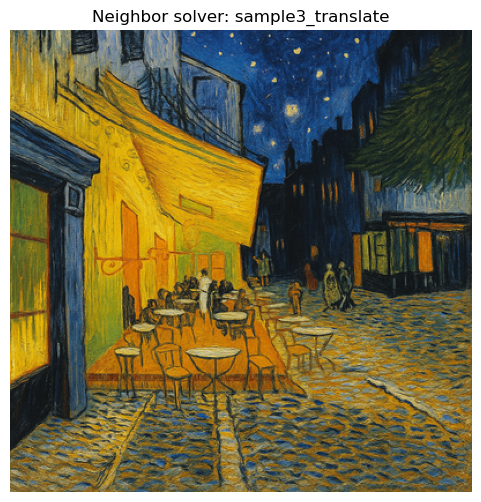

Saved -> ./outputs_neighbor\sample3_translate_neighbor.png


array([[[ 49, 113, 128],
        [ 62, 117, 131],
        [ 68, 100, 100],
        ...,
        [ 43,  34,  23],
        [ 28,  25,  18],
        [ 31,  27,  20]],

       [[ 56, 117, 129],
        [ 78, 144, 158],
        [ 71, 103,  99],
        ...,
        [ 49,  40,  28],
        [ 32,  27,  19],
        [ 28,  26,  19]],

       [[ 56, 112, 122],
        [ 70, 122, 129],
        [ 65,  97,  95],
        ...,
        [ 41,  33,  21],
        [ 32,  28,  19],
        [ 29,  26,  19]],

       ...,

       [[ 71, 143, 173],
        [ 42, 100, 130],
        [ 58, 119, 148],
        ...,
        [ 32,  95, 131],
        [ 33,  90, 124],
        [ 31,  88, 122]],

       [[ 72, 114, 127],
        [ 63, 106, 121],
        [ 60, 111, 134],
        ...,
        [ 39, 102, 137],
        [ 30, 103, 141],
        [ 23,  90, 126]],

       [[ 81, 117, 124],
        [ 91, 144, 154],
        [ 80, 123, 135],
        ...,
        [ 33,  91, 124],
        [ 30, 101, 144],
        [ 29, 103, 145]]

In [97]:
solve_puzzle_neighbor("./data/more_samples/sample3/sample3_translate.rgb")


=== Solving: ./data/more_samples/sample3/sample3_rotate.rgb ===
Reading input...
Segmenting pieces...
Found 20 pieces.
Deskewing pieces (per-piece minAreaRect)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
sample3_rotate.rgb: 20 pieces
Estimated grid: 4 x 5 side_len 393
starting iteration: 0
starting iteration: 1
starting iteration: 2
starting iteration: 3
starting iteration: 4
starting iteration: 5
starting iteration: 6
starting iteration: 7
starting iteration: 8
starting iteration: 9
starting iteration: 10
starting iteration: 11
starting iteration: 12
starting iteration: 13
starting iteration: 14
starting iteration: 15
starting iteration: 16
starting iteration: 17
starting iteration: 18
starting iteration: 19
piece 0 : [0, 0]
piece 1 : [0, 1]
piece 2 : [0, 2]
piece 3 : [0, 3]
piece 4 : [1, 3]
piece 5 : [2, 3]
piece 6 : [3, 3]
piece 7 : [4, 3]
piece 8 : [4, 2]
piece 9 : [4, 1]
piece 10 : [4, 0]
piece 11 : [3, 0]
piece 12 : [2, 0]
piece 13 : [1, 0

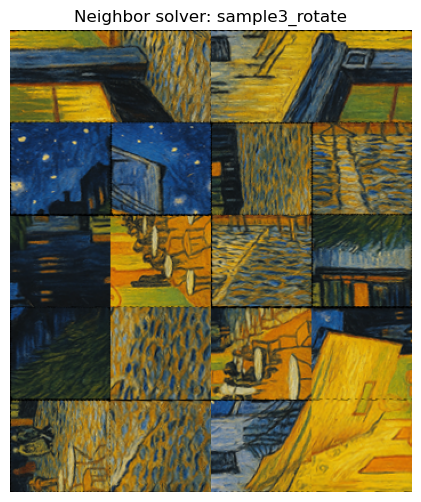

Saved -> ./outputs_neighbor\sample3_rotate_neighbor.png


array([[[  3,  18,  38],
        [  1,   3,   8],
        [  0,   0,   0],
        ...,
        [  0,   2,   2],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 15,  96, 184],
        [ 12,  88, 180],
        [ 10,  74, 143],
        ...,
        [ 17, 169, 209],
        [ 12, 142, 176],
        [  8, 102, 139]],

       [[ 14, 149, 207],
        [ 13, 162, 214],
        [ 12, 153, 212],
        ...,
        [ 10, 172, 217],
        [  9, 179, 223],
        [ 12, 144, 207]],

       ...,

       [[  4,   4,   3],
        [ 25,  24,  19],
        [ 25,  22,  18],
        ...,
        [ 21, 152, 186],
        [ 18, 154, 189],
        [ 18, 155, 188]],

       [[  9,   7,   5],
        [ 28,  24,  17],
        [ 26,  22,  18],
        ...,
        [ 17, 164, 202],
        [ 16, 169, 208],
        [ 17, 170, 207]],

       [[  0,   0,   0],
        [  1,   1,   1],
        [ 10,   8,   7],
        ...,
        [  8, 113, 142],
        [  9, 121, 150],
        [ 14, 128, 157]]

In [98]:
solve_puzzle_neighbor("./data/more_samples/sample3/sample3_rotate.rgb")

Reading input...
Segmenting pieces...
Found 20 pieces.
Deskewing pieces (mode='translate')...
Building rotations + mask-aware signatures...
Done preprocessing.


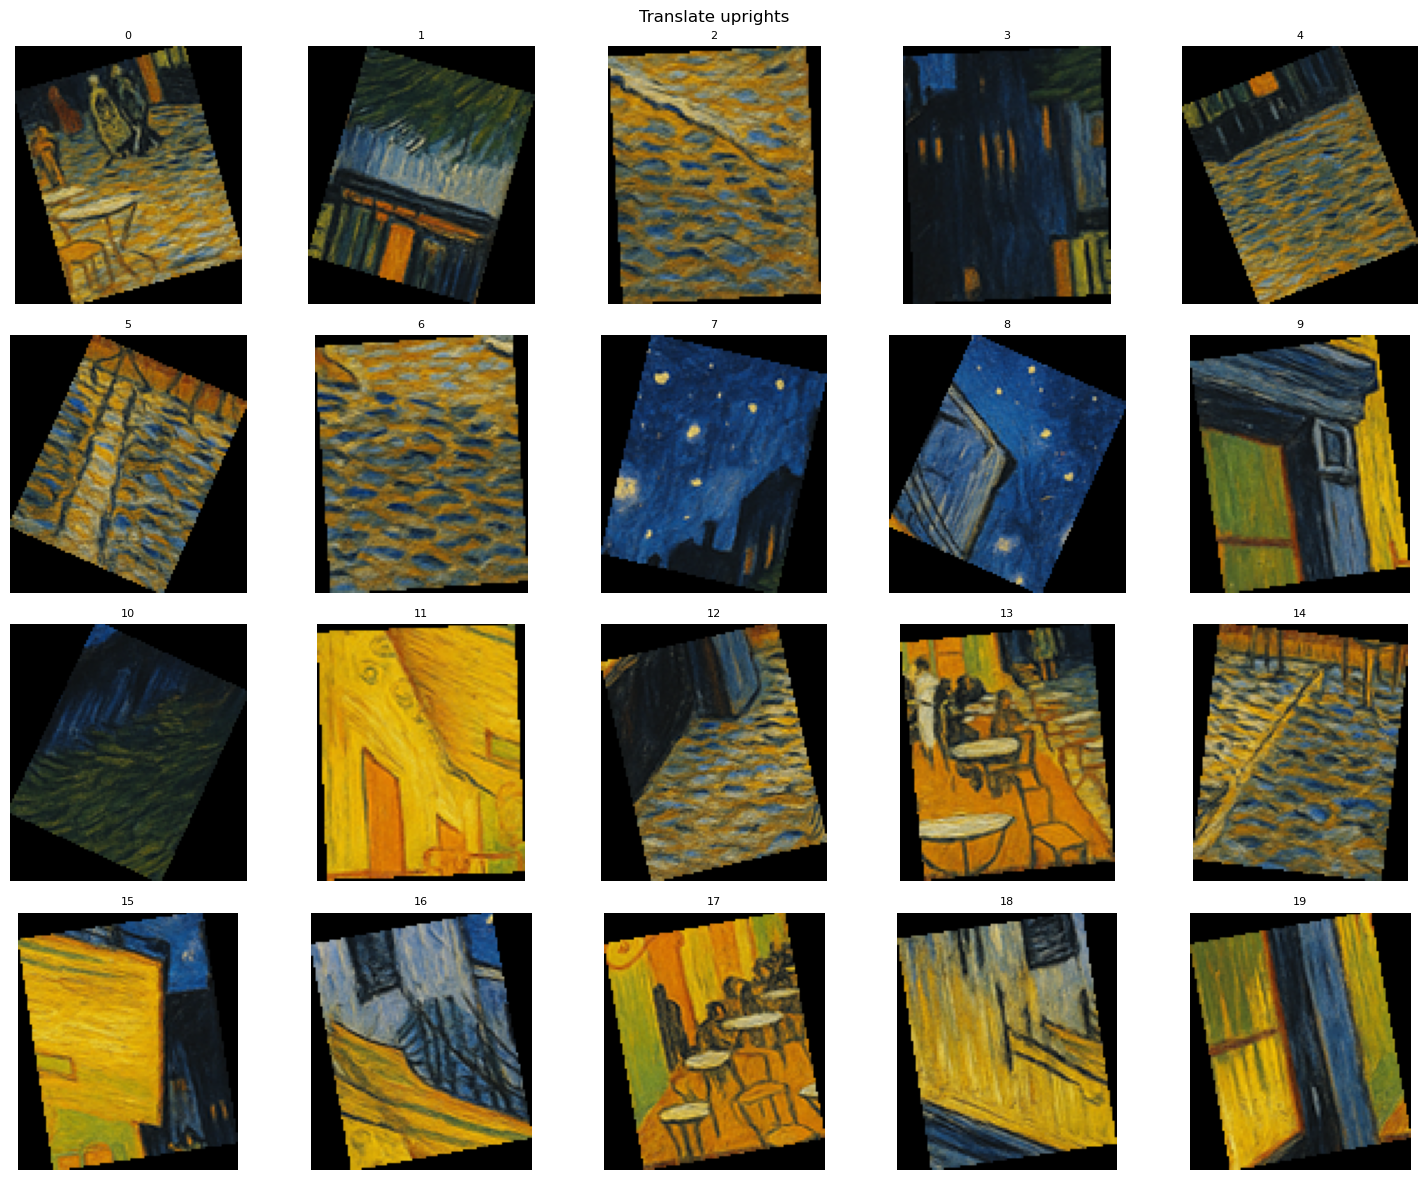

Reading input...
Segmenting pieces...
Found 20 pieces.
Deskewing pieces (mode='rotate')...
Building rotations + mask-aware signatures...
Done preprocessing.


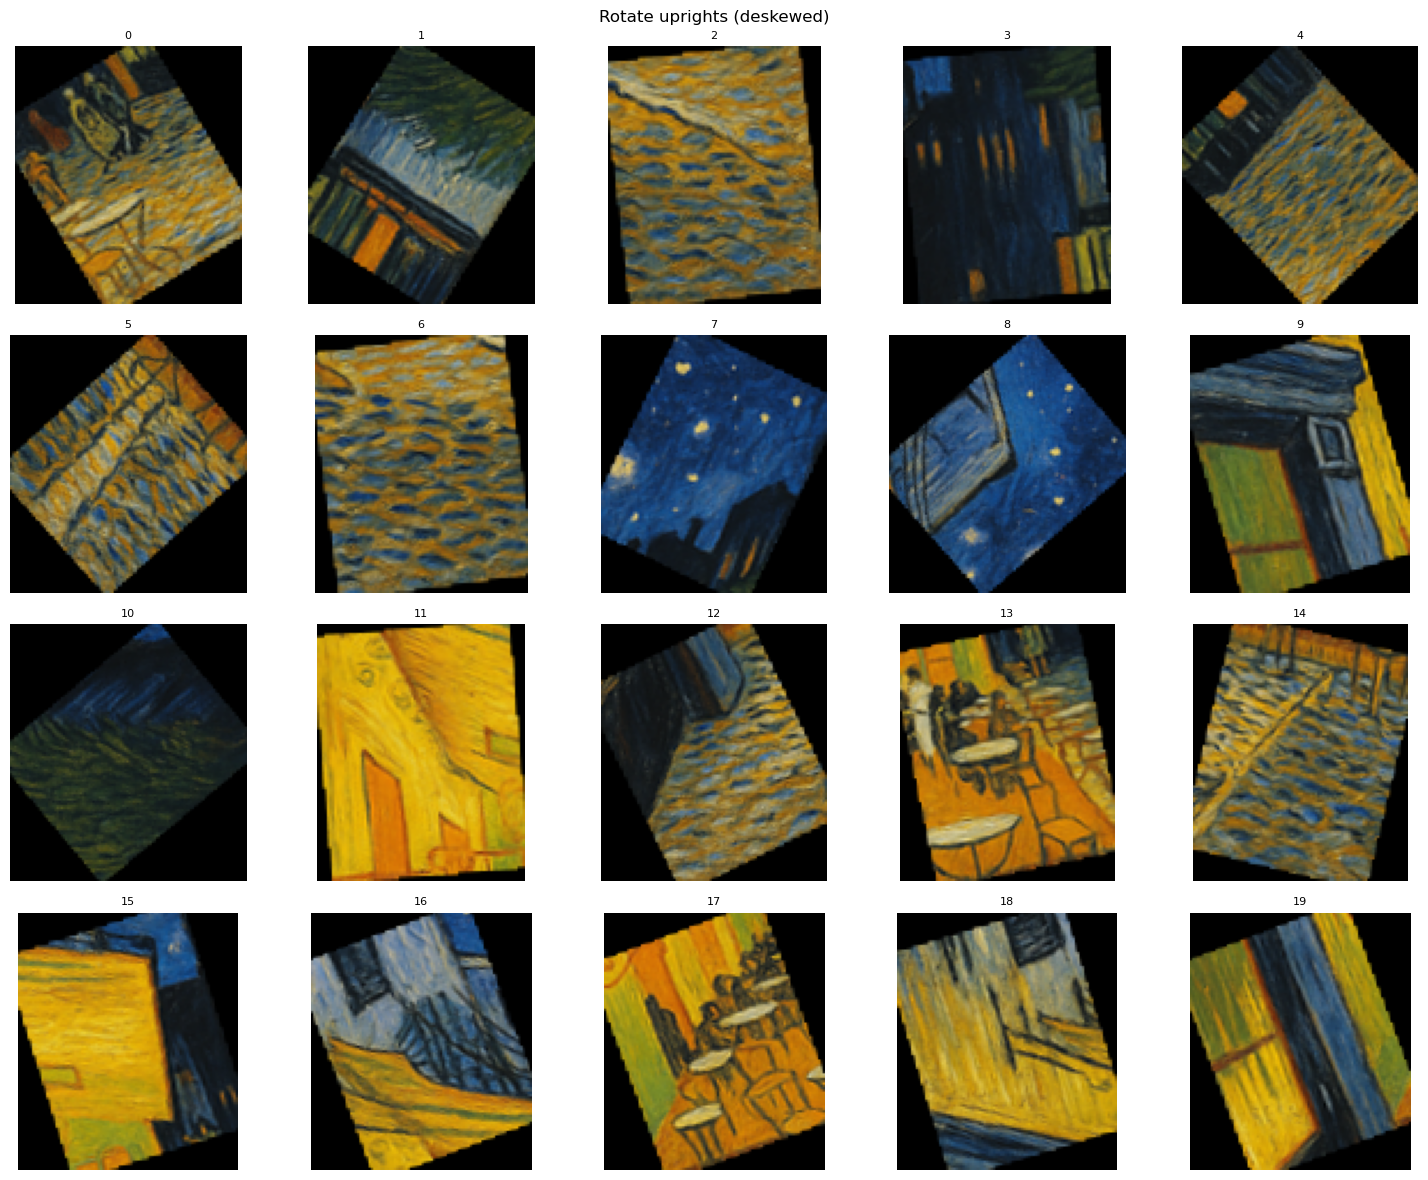

In [128]:
# translate case (should look like your original upright pieces)
path_t = "./data/more_samples/sample3/sample3_rotate.rgb"
upr_t, m_t, rot_t, rmask_t, sig_t = load_puzzle_pieces_masked(path_t, mode="translate")
show_uprights(upr_t, title="Translate uprights")

# rotate case (should now be de-tilted piece-wise)
path_r = "./data/more_samples/sample3/sample3_rotate.rgb"
upr_r, m_r, rot_r, rmask_r, sig_r = load_puzzle_pieces_masked(path_r, mode="rotate")
show_uprights(upr_r, title="Rotate uprights (deskewed)")
